In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784')
X, y = np.array(mnist.data), np.array(mnist.target).astype(int)


In [5]:
sample_size = 5000
indices = np.random.choice(X.shape[0], sample_size, replace=False)
X = X[indices]
y = y[indices]

X = X / 255.0
X = X - np.mean(X, axis=0)

print("Data Shape: ", X.shape)
print("Labels Shape: ", y.shape)


Data Shape:  (5000, 784)
Labels Shape:  (5000,)


In [ ]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

print("PCA Shape: ", X_pca.shape)

PCA Shape:  (5000, 50)


In [8]:
def compute_distance_matrix(X):
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return D

def compute_similarity_matrix(D, perplexity=30.0):
    (n, _) = D.shape
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log2(perplexity)

    for i in range(n):
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        Hdiff = 1.0
        max_tries = 50

        for _ in range(max_tries):
            P_i = np.exp(-Di * beta[i])
            P_i_sum = np.sum(P_i)
            P_i /= P_i_sum
            H = -np.sum(P_i * np.log2(P_i))
            Hdiff = H - logU

            if np.abs(Hdiff) < 1e-5:
                break

            if Hdiff > 0:
                betamin = beta[i]
                if betamax == np.inf:
                    beta[i] *= 2.0
                else:
                    beta[i] = (beta[i] + betamax) / 2.0
            else:
                betamax = beta[i]
                if betamin == -np.inf:
                    beta[i] /= 2.0
                else:
                    beta[i] = (beta[i] + betamin) / 2.0

        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = P_i

    P = (P + P.T) / (2 * n)
    return P

def tsne(X, no_dims=2, max_iter=400, learning_rate=500):
    (n, _) = X.shape
    Y = np.random.randn(n, no_dims) * 0.0001
    P = compute_similarity_matrix(compute_distance_matrix(X))
    P = np.maximum(P, 1e-12)

    for iter in range(max_iter):
        sum_Y = np.sum(np.square(Y), 1)
        Q_num = 1 / (1 + np.add(np.add(-2 * np.dot(Y, Y.T), sum_Y).T, sum_Y))
        np.fill_diagonal(Q_num, 0)
        Q = Q_num / np.sum(Q_num)
        Q = np.maximum(Q, 1e-12)

        # Gradient calculation
        PQ = P - Q
        dY = np.zeros_like(Y)
        for i in range(n):
            dY[i, :] = 4 * np.sum((PQ[:, i] * Q_num[:, i])[:, np.newaxis] * (Y[i, :] - Y), axis=0)

        # Update Y
        Y += learning_rate * dY
        Y -= np.mean(Y, axis=0)

        # Monitor progress
        if iter % 10 == 0:
            cost = np.sum(P * np.log(P / Q))
            print(f"Iteration {iter}: Error = {cost}")

    return Y


Iteration 0: Error = 3.6320598877964145
Iteration 10: Error = 3.6320602668954645
Iteration 20: Error = 3.6324881460743548
Iteration 30: Error = 3.6426809259424417
Iteration 40: Error = 3.7027876371647794
Iteration 50: Error = 3.8354345428506873
Iteration 60: Error = 3.9996579809688253
Iteration 70: Error = 4.165814812068775
Iteration 80: Error = 4.320486568648336
Iteration 90: Error = 4.456961526511907
Iteration 100: Error = 4.571787736085625
Iteration 110: Error = 4.668405580521222
Iteration 120: Error = 4.749467738311161
Iteration 130: Error = 4.818039960983549
Iteration 140: Error = 4.877020713411228
Iteration 150: Error = 4.928486317093435
Iteration 160: Error = 4.973372321534448
Iteration 170: Error = 5.013166035233732
Iteration 180: Error = 5.049012250312334
Iteration 190: Error = 5.081841666120602
Iteration 200: Error = 5.112289786543384
Iteration 210: Error = 5.140723715856203
Iteration 220: Error = 5.167109022425844
Iteration 230: Error = 5.191662301560099
Iteration 240: Error

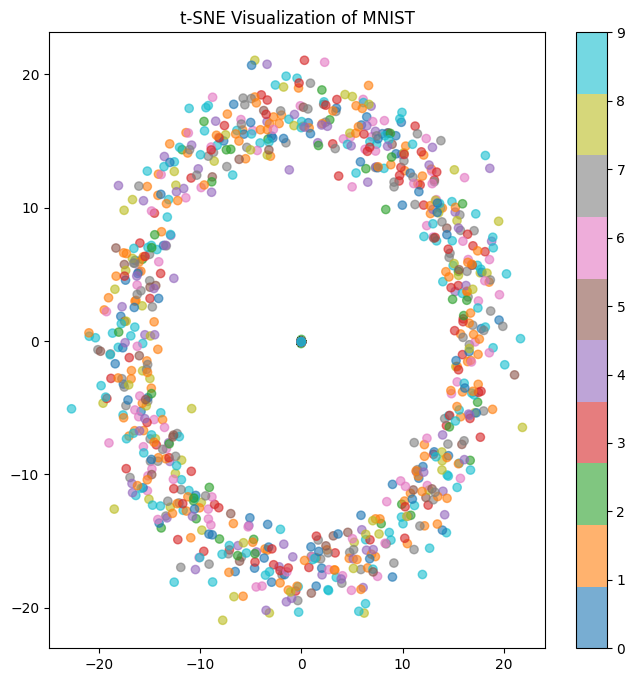

In [9]:
Y = tsne(X_pca)

# Plot the t-SNE embedding
plt.figure(figsize=(8, 8))
plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap='tab10', alpha=0.6)
plt.colorbar()
plt.title("t-SNE Visualization of MNIST")
plt.show()